[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/usnistgov/AFL-agent/blob/main/docs/source/tutorials/autosas_tutorial.ipynb)

# AutoSAS Tutorial

This tutorial demonstrates how to use AutoSAS to fit small-angle scattering (SAS) data with different models. We'll explore how to:
- Load and prepare SAS data
- Set up different SAS models (Guinier, Power Law, and Polymer Excluded Volume)
- Fit the models to the data
- Compare and evaluate the fits

## Google Colab Setup

Only uncomment and run the next cell if you are running this notebook in Google Colab or if don't already have the AFL-agent package installed.

In [ ]:
# !pip install git+https://github.com/usnistgov/AFL-agent.git

## Getting Started

First, let's import the necessary packages and load our example dataset:

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from AFL.double_agent import *
from AFL.double_agent.AutoSAS import AutoSAS


Next, let's load the example dataset. 

In [5]:
from AFL.double_agent.data import example_dataset2

# Load example dataset
ds = example_dataset2()
ds

<xarray.Dataset> Size: 85kB
Dimensions:  (sample: 50, q: 100)
Coordinates:
  * q        (q) float64 800B 0.001 0.001072 0.00115 ... 0.8697 0.9326 1.0
Dimensions without coordinates: sample
Data variables:
    I        (sample, q) float64 40kB 1.08e+04 5.558e+03 6.288e+03 ... 1.1 1.002
    dI       (sample, q) float64 40kB 968.7 776.0 629.9 ... 0.09923 0.09923
    model    (sample) <U19 4kB 'broad_peak' 'broad_peak' ... 'mass_fractal'

 Let's plot the data for each model type in the dataset. This will help us visualize the different scattering patterns we're working with. We'll create a separate plot for each model type, showing all samples of that type on a log-log scale.


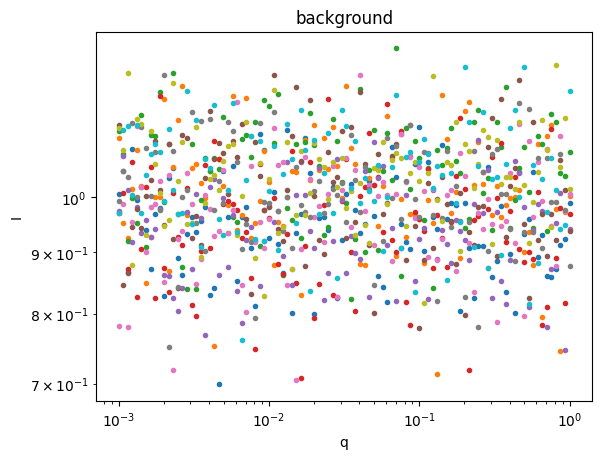

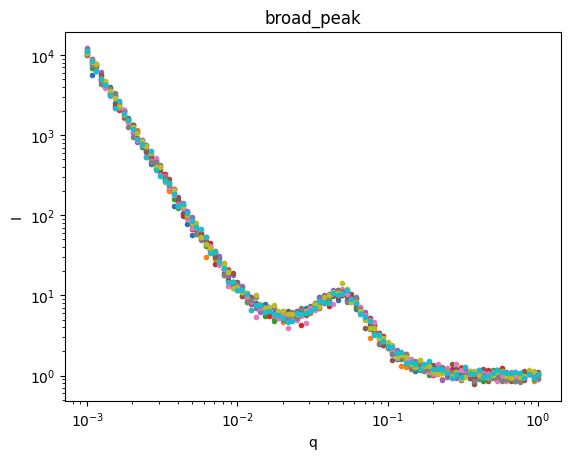

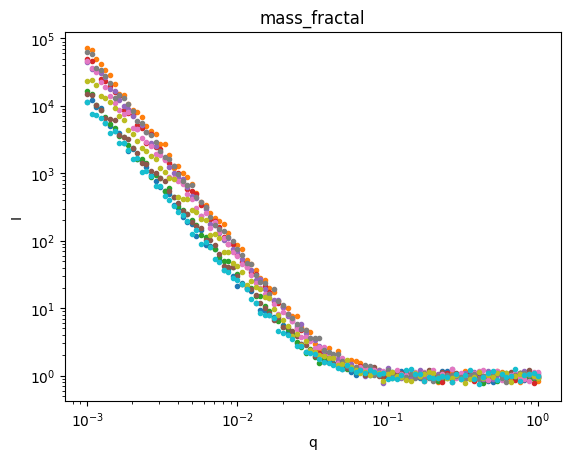

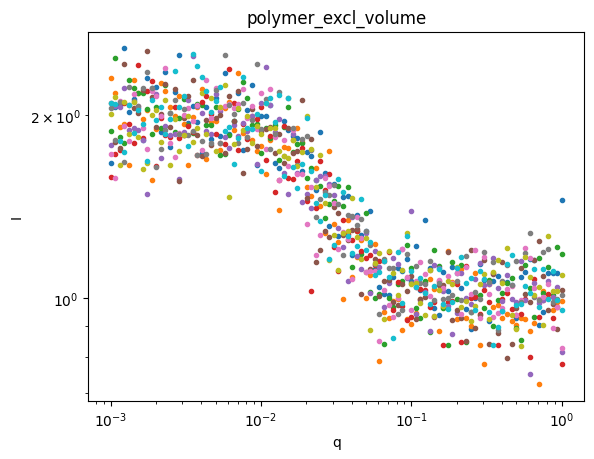

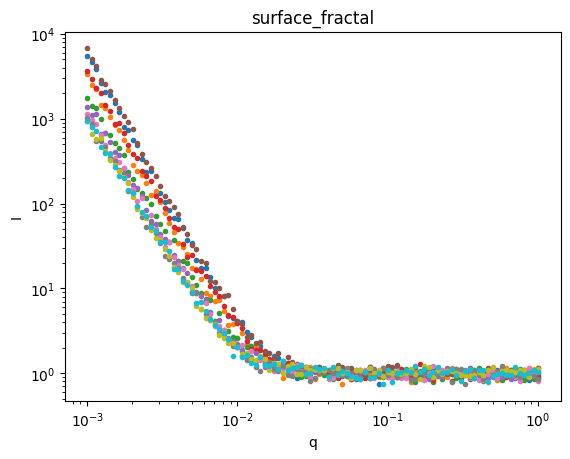

In [7]:

for model,sds in ds.groupby('model'):
    plt.figure()
    sds.I.plot.line(x='q',xscale='log',yscale='log',marker='.',ls='None',add_legend=False);
    plt.gca().set_title(model)

## First Steps: Fitting a Single Model

Let's start by picking a single model from the example dataset and fitting it. We'll choose the mass_fractal to begin

In [8]:
ds1 = ds.where(ds.model == 'mass_fractal',drop=True)
ds1

<xarray.Dataset> Size: 17kB
Dimensions:  (sample: 10, q: 100)
Coordinates:
  * q        (q) float64 800B 0.001 0.001072 0.00115 ... 0.8697 0.9326 1.0
Dimensions without coordinates: sample
Data variables:
    I        (sample, q) float64 8kB 1.141e+04 1.205e+04 9.604e+03 ... 1.1 1.002
    dI       (sample, q) float64 8kB 1.348e+03 1.104e+03 ... 0.09923 0.09923
    model    (sample) object 80B 'mass_fractal' ... 'mass_fractal'

The first step to AutoSAS is to define which models we'd like to fit. Let's start with a single model

The model inputs are defined as a list of dictionaries, where each dictionary specifies:
- name: A user-defined name for the model
- sasmodel: The name of the model in the sasmodels library to use
- fit_params: A dictionary of parameters for the model, where:
  - Parameters with "bounds" will be fit within those bounds
  - Parameters without bounds will be held constant at the specified value

In the example below, "power" and "scale" will be fit since they have bounds,
while "background" will be held constant at 1.0


In [9]:
model_inputs = [
    {
        "name": "surface_fractal", # your name for the model, can be anything
        "sasmodel": "power_law", # the name of the sasmodel in the sasmodels library
        "fit_params": {
            "power": {"value": 4, "bounds": (3, 4)},
            "scale": {"value": 1.0, "bounds": (1e-6,1e-3)},
            "background": {"value": 1.0,},
        },
    },
]

Now we'll create a `Pipeline` with a single `AutoSAS` pipeline operation.

The AutoSAS pipeline operation takes several key arguments:

- sas_variable: The name of the variable containing the SAS intensity data
- sas_err_variable: The name of the variable containing the uncertainty in the intensity data
- q_dim: The name of the dimension containing the q values
- output_prefix: A prefix to add to all output variables from the fit
- model_inputs: A list of dictionaries defining the models to fit, as described above

Additional optional arguments include:
- sample_dim: The name of the sample dimension (default: 'sample')
- fit_range: A tuple of (qmin, qmax) to restrict the q range used for fitting
- max_evals: Maximum number of function evaluations for the fit (default: 1000)
- method: The optimization method to use (default: 'leastsq')


In [10]:
with Pipeline() as p:
    AutoSAS(
        sas_variable='I',
        sas_err_variable='dI',
        q_dim = 'q',
        output_prefix='fit',
        model_inputs=model_inputs,
    )
p.print()

PipelineOp                               input_variable ---> output_variable
----------                               -----------------------------------
0  ) <AutoSAS>                           ['q', 'I', 'dI'] ---> ['fit_all_chisq']

Input Variables
---------------
0) q
1) I
2) dI

Output Variables
----------------
0) fit_all_chisq


Now we're ready to fit! 

In [14]:
ds_result = p.calculate(ds1)
ds_result

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/tbm/CursorProjects/AFL-agent/AFL/double_agent/AutoSAS.py:534: RuntimeWarning: invalid value encountered in divide
  probabilities = likelihoods / np.sum(likelihoods)


<xarray.Dataset> Size: 24kB
Dimensions:                    (sample: 10, q: 100, models: 1,
                                surface_fractal_params: 3,
                                fit_q_surface_fractal: 34)
Coordinates:
  * q                          (q) float64 800B 0.001 0.001072 ... 0.9326 1.0
  * models                     (models) <U15 60B 'surface_fractal'
  * surface_fractal_params     (surface_fractal_params) <U26 312B 'surface_fr...
  * fit_q_surface_fractal      (fit_q_surface_fractal) float64 272B 0.01 ... 0.1
Dimensions without coordinates: sample
Data variables:
    I                          (sample, q) float64 8kB 1.141e+04 ... 1.002
    dI                         (sample, q) float64 8kB 1.348e+03 ... 0.09923
    model                      (sample) object 80B 'mass_fractal' ... 'mass_f...
    sas_fit_sample             (sample) int64 80B 0 1 2 3 4 5 6 7 8 9
    fit_all_chisq              (sample, models) float64 80B 1.498e+05 ... 1.7...
    probabilities              (sample, models) float64 80B nan nan ... nan nan
    surface_fractal_fit_val    (surface_fractal_params, sample) float64 240B ...
    surface_fractal_fit_err    (surface_fractal_params, sample) float64 240B ...
    fit_I_surface_fractal      (sample, fit_q_surface_fractal) float64 3kB 1....
    residuals_surface_fractal  (sample, fit_q_surface_fractal) float64 3kB 35...

This is a large and complicated dataset, but it contains all of the information from the fit, including:

- The fitted parameter values for each model (e.g. `surface_fractal_fit_val`) 
- The uncertainties in the fitted parameters (e.g. `surface_fractal_fit_err`)
- The model intensities at each q value (e.g. `fit_I_surface_fractal`)
- The residuals between the model and data (e.g. `residuals_surface_fractal`) 
- The chi-squared values for each fit (`fit_all_chisq`)
- The q values used for the fit (e.g. `fit_q_surface_fractal`)

We can use this information to evaluate the quality of the fits and compare different models. Let's plot some of the fits:

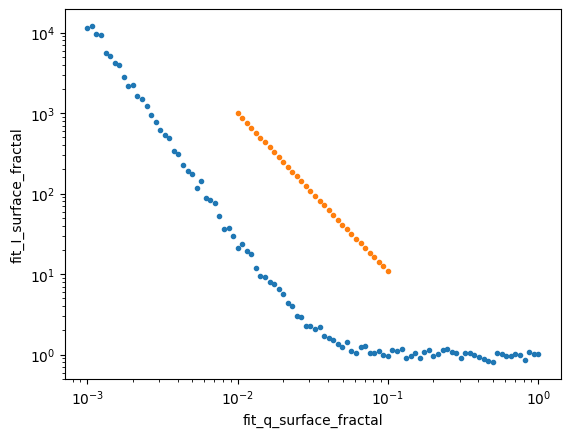

In [16]:
ds_result.isel(sample=0).I.plot.line(x='q',xscale='log',yscale='log',marker='.',ls='None',add_legend=False);
ds_result.isel(sample=0).fit_I_surface_fractal.plot.line(x='fit_q_surface_fractal',xscale='log',yscale='log',marker='.',ls='None',add_legend=False);


## Visualizing the Results

Let's plot the data and the fitted models:

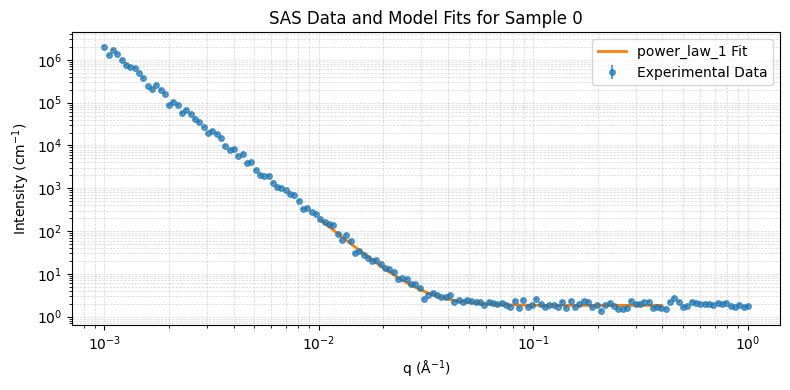

In [9]:
# Plot the first sample data and the fitted model
sample_idx = 0

plt.figure(figsize=(8, 4))

# Plot the experimental data with error bars
plt.errorbar(
    ds_result.q.values,
    ds_result.I.isel(sample=sample_idx).values,
    yerr=ds_result.dI.isel(sample=sample_idx).values,
    fmt='o',
    markersize=4,
    alpha=0.7,
    label='Experimental Data'
)

# Plot the fitted models
for model_name in ds_result.models.values:
    q_key = f"fit_q_{model_name}"
    i_key = f"fit_I_{model_name}"
    
    if q_key in ds_result and i_key in ds_result:
        plt.plot(
            ds_result[q_key].values,
            ds_result[i_key].isel(sample=sample_idx).values,
            '-',
            linewidth=2,
            label=f'{model_name} Fit'
        )

plt.xscale('log')
plt.yscale('log')
plt.xlabel('q (Å$^{-1}$)')
plt.ylabel('Intensity (cm$^{-1}$)')
plt.title(f'SAS Data and Model Fits for Sample {sample_idx}')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()


In [35]:
from AFL.double_agent.AutoSAS import SASFitter

# Initialize SASFitter with our configuration
fitter = SASFitter(
    model_inputs=model_inputs,
    fit_method=None,
    resolution=None
)

# Set the data to fit
fitter.set_sasdata(
    dataset=ds,
    sample_dim='sample',
    q_variable='q',
    sas_variable='I',
    sas_err_variable='dI'
)

# Run the fitting
_, autosas_fit = fitter.fit_models(fit_method=None)

KeyError: 'error'

In [34]:
fitter.report['model_fits'][0]

[{'name': 'guinier',
  'sasmodel': 'guinier',
  'chisq': 272.48357320694504,
  'cov': [[0.0005994808899430736,
    0.00013506495813025768,
    -0.0005323405483805674],
   [0.00013506495813025768, 0.0017020068020967615, 3.28504664053339e-05],
   [-0.0005323405483805674, 3.28504664053339e-05, 0.0012319716394310544]],
  'output_fit_params': {'rg': {'value': 21.3830038843587,
    'error': 1.6015693473645598},
   'scale': {'value': 4.066319010268407, 'error': 0.24600311986561874},
   'background': {'value': 0.1, 'error': 0.3055602859228135}}},
 {'name': 'power_law',
  'sasmodel': 'power_law',
  'chisq': 68363877490755.35,
  'cov': [[1.4456313066567264e-16, 0.0, 0.0],
   [0.0, 1.4456015280228447e-16, -7.492732796029785e-16],
   [0.0, -7.492732796029785e-16, 3.9534305008085745e-15]],
  'output_fit_params': {'power': {'value': 3.9999999322648194,
    'error': 1.3239737274241106e-08},
   'scale': {'value': 0.9467521017377567, 'error': 6.788920897425345e-08},
   'background': {'value': 1e-06, 'e

## Model Selection

AutoSAS provides several methods for model selection. Let's use the Bayesian Information Criterion (BIC) to select the best model:

In [ ]:
from AFL.double_agent.AutoSAS import ModelSelectBIC

# Create model selector
model_selector = ModelSelectBIC(
    all_chisq_var='all_chisq',
    model_names_var='models',
    sample_dim='sample',
    model_inputs=model_inputs
)

# Select best model
selection_results = model_selector.calculate(fit_results)

# Print results
print("\nBest model selection using BIC:")
for sample_idx, (model_name, bic_value) in enumerate(zip(
    selection_results.output['BIC_label_names'].values,
    selection_results.output['BIC'].values)):
    print(f"Sample {sample_idx}: {model_name}")

## Conclusion

In this tutorial, we've learned how to:
- Set up different SAS models with AutoSAS
- Fit multiple models to SAS data
- Visualize and compare the fits
- Use model selection criteria to choose the best model

The choice of model depends on various factors including the q-range of interest, the physical system being studied, and the quality of the fits. AutoSAS makes it easy to try different models and compare their performance.